# Hartree-Fock use cases illustration
In this notebook, we will explore some use-cases of Hartree-Fock to jump-start your enthusiasm for this computational method.
We will:
- Compute MO scheme energies
- Visualise electron densities
- Generate some cube files for visualising the HF MO's directly.

In [1]:
# import packages
import pyscf
import numpy as np
import matplotlib.pyplot as plt

We first need to define a function that runs our HF calculation for a given structure. Here, we use pyscf.

In [2]:
def perform_hf_calc(structure, n_unpaired=0, only_occ=False):
    # create molecule and run UHF calculation
    mol = pyscf.gto.Mole()
    mol.build(
        atom = structure, # default distance unit is angstrom
        basis = "sto-3g",
        unit = 'bohr',  # specify Bohr units: default is A but underlying calculations of AO stuff is in Bohr.
        symmetry="C1",
        spin=n_unpaired,
    )
    n_electrons = mol.nelec[0] + mol.nelec[1]
    if n_electrons % 2:
        mf = pyscf.scf.UHF(mol)
    else:
        mf = pyscf.scf.RHF(mol) # init HF object
    energy = mf.kernel() # run SCF

    mo_coeff = mf.mo_coeff
    if only_occ:
        n_occ = sum(mf.mo_occ > 0)
        mo_energy = mf.mo_energy[:n_occ]
    else:
        mo_energy = mf.mo_energy

    return energy, mo_coeff, mo_energy

## 1. Computing MO scheme energies
Here, we will use HF to determine the MO orbital energies of a molecule and two of its fragments.

In [3]:
def get_fragmented_calc_data(mol, fragment1, fragment2):
    """get the MO coefficients and energies of a molecule and its fragments.
    input for each:
    [structure (str), n_unpaired_electrons (int)]
    """
    calc_data = {}
    for name, content in zip(['mol', 'frag1', 'frag2'], [mol, fragment1, fragment2]):
        calc_data[name] = perform_hf_calc(*content)
    return calc_data

We will illustrate for CO.

In [4]:
mol = [
"""
C -0.5 0 0
O 0.5 0 0
""", 0
]
fragment1 = [
"""
C 0 0 0
""", 0
]
fragment2 = [
"""
O 0 0 0
""", 0
]

In [5]:
calc_data = get_fragmented_calc_data(mol, fragment1, fragment2)

converged SCF energy = -105.586500125414
converged SCF energy = -37.0895866394329
converged SCF energy = -73.6618168979008


In [6]:
# calc_data

In [7]:
def plot_MO_scheme(calc_data):
    mol_energies = calc_data['mol'][2]
    frag1_energies = calc_data['frag1'][2].flatten()
    frag2_energies = calc_data['frag2'][2].flatten()

    plt.figure(figsize=(6, 5))
    # Define positions for each species on the x-axis
    positions = {'frag1': 1, 'mol': 2, 'frag2': 3}
    # plot lines for each MO's energy.
    for i, energy in enumerate(frag1_energies):
        plt.plot([positions['frag1'] - 0.1, positions['frag1'] + 0.1], [energy, energy], 'b-', zorder=100)

    for energy in mol_energies:
        plt.plot([positions['mol'] - 0.1, positions['mol'] + 0.1], [energy, energy], 'b-', zorder=100)

    for i, energy in enumerate(frag2_energies):
        plt.plot([positions['frag2'] - 0.1, positions['frag2'] + 0.1], [energy, energy], 'b-', zorder=100)
    
    # clean up mpl graph
    plt.xticks(list(positions.values()), list(positions.keys()))
    plt.ylabel("Orbital Energy $\epsilon_0$ (a.u.)")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

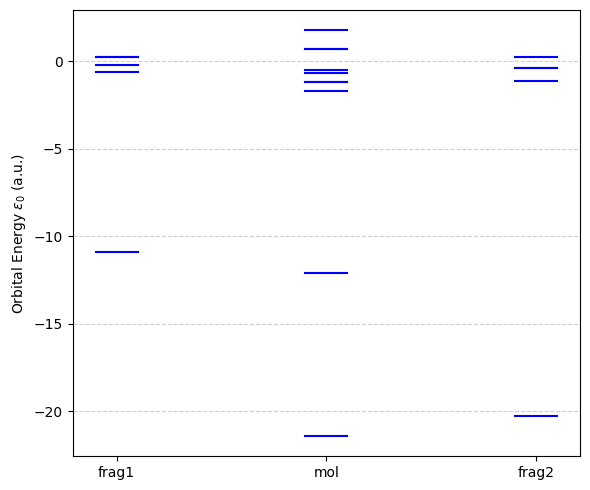

In [8]:
plot_MO_scheme(calc_data)

## 2. Plotting the electron density
For an overview on how we do this, see [our notebook on visualising the electron density](tutorials/electron_density_visualisation.ipynb).

In [9]:
def plot_density(structure, use_log=False):
    # create molecule and run RHF calculation
    mol = pyscf.gto.Mole()
    mol.build(
        atom = structure, # default distance unit is angstrom
        basis = "sto-3g",
        unit = 'bohr',  # specify Bohr units: default is A but underlying calculations of AO stuff is in Bohr.
        symmetry="C1",
    )
    mf = pyscf.scf.RHF(mol) # init HF object
    mf.kernel() # run SCF

    def get_el_density_at_r(r_vec, mol, hf_obj):
        # get density matrix
        density_matrix = hf_obj.make_rdm1()
        # get value of each AO at location r
        ao_values = mol.eval_gto('GTOval_cart', np.array([r_vec]))
        ao_values_matrix = np.einsum('i, j -> ij', ao_values[0], ao_values[0])

        # perform contraction
        return np.einsum('ij, ij ->', density_matrix, ao_values_matrix)

    # Define the grid resolution and range
    x_min, x_max = -3.0, 3.0  # Bohr
    y_min, y_max = -3.0, 3.0  # Bohr
    grid_points = 144  # Number of points along each axis

    # Create the x and y coordinates for the grid
    x_coords = np.linspace(x_min, x_max, grid_points)
    y_coords = np.linspace(y_min, y_max, grid_points)

    # Initialize the 2D array to store electron densities
    electron_density = np.zeros((grid_points, grid_points))

    # Compute electron density at each point in the xy-plane
    for i, x in enumerate(x_coords):
        for j, y in enumerate(y_coords):
            # Create the r_vec for the xy-plane, z = 0
            r_vec = [x, y, 0.0]
            # Compute electron density at this point
            electron_density[i, j] = get_el_density_at_r(r_vec, mol, mf)

    # Create a meshgrid for plotting
    X, Y = np.meshgrid(x_coords, y_coords)

    # Plot the electron density using contour plot
    plt.figure(figsize=(8, 6))
    if use_log:
        cp = plt.contourf(X, Y, np.log(electron_density), levels=100, cmap='viridis')
        plt.colorbar(cp, label='log(dlectron density)')
    else:
        cp = plt.contourf(X, Y, electron_density, levels=100, cmap='viridis')
        plt.colorbar(cp, label='electron density')
    plt.xlabel('x (au)')
    plt.ylabel('y (au)')
    plt.title('Electron Density on xy-plane')
    plt.show()

converged SCF energy = -105.586500125414


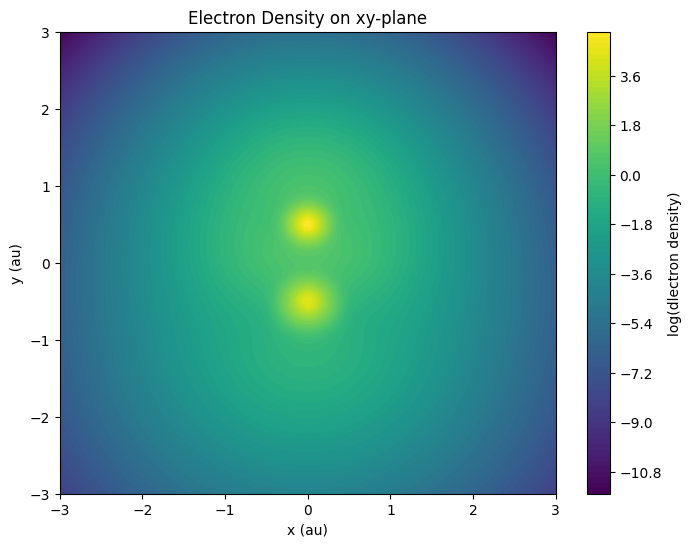

In [10]:
plot_density(mol[0], use_log=True)

Let's also do this for a more exciting molecule, benzene.

In [11]:
benzene = """
    C   0.000000   1.396792   0.000000
    H   0.000000   2.481081   0.000000
    C  -1.209657   0.698396   0.000000
    H  -2.147732   1.240540   0.000000
    C  -1.209657  -0.698396   0.000000
    H  -2.147732  -1.240540   0.000000
    C   0.000000  -1.396792   0.000000
    H   0.000000  -2.481081   0.000000
    C   1.209657  -0.698396   0.000000
    H   2.147732  -1.240540   0.000000
    C   1.209657   0.698396   0.000000
    H   2.147732   1.240540   0.000000
    """

Running the next code will take approx 1-2 minutes.

converged SCF energy = -212.312184413665


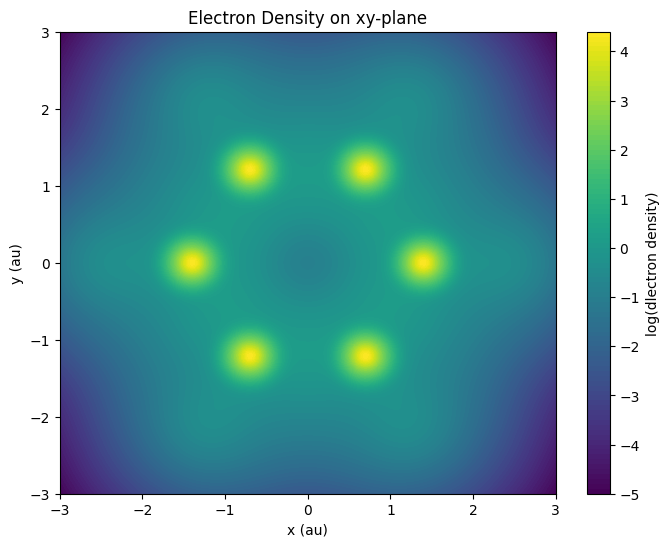

In [12]:
plot_density(benzene, use_log=True)

## 3. Visualising the MOs directly
We can visualise MOs using cube files. For this, see [our introductory notebook on generating cube files with pyscf](tutorials/orbital_visualization_pyscf.ipynb).

In [13]:
from pyscf.tools import cubegen

from pyscf import __config__
# Set the desired extent (in Bohr) globally
__config__.cubegen_box_margin = 5.0  

# reload the cubegen module
from importlib import reload
reload(cubegen)

def generate_cube_files(structure, molecule_name, basis_set='sto-3g', cubefile_folder='cube_files'):
    """generate cube files for each MO of a specified molecule, using hartree-fock in pyscf.

    Args:
        structure (str): molecular structure
        molecule_name (str): name of molecule for saving cube files
        basis_set (str, optional): basis set to perform HF calculations in. Defaults to 'sto-3g'.
        cubefile_folder (str, optional): folder to store cube files in. Defaults to 'cube_files'.
    """
    # build molecule object
    mol = pyscf.gto.Mole()
    mol.build(
        atom = structure,
        basis = basis_set,
    )
    mf = pyscf.scf.RHF(mol) # init HF object
    mf.kernel() # run SCF

    # generate MOs
    for i, moocc in enumerate(mf.mo_occ):
        a = cubegen.orbital(mol, f"cube_files/MO_{molecule_name}_{i}.cube", mf.mo_coeff[:, i])

In [14]:
# test for CO:
generate_cube_files("""C 0 0 0; O 0 0 1""", "CO")

converged SCF energy = -111.143611706552
